# Fluid Flow Example

consider the nonlinear mean-field model of fluid flow past a circular cylinder at Reynolds number 100, described by these equations:
$$
\frac{\partial x_{1}}{\partial t} = \mu x_{1} - \omega x_{2} + A x_{1}x_{3}
$$
$$
\frac{\partial x_{2}}{\partial t} = \omega x_{1} + \mu x_{2} + Ax_{2}x_{3}
$$
$$
\frac{\partial x_{3}}{\partial t} = -\lambda(x_{3} - {x_{1}}^{2} - {x_{2}}^{2}) 
$$

Where $\mu = 0.1, \omega = 1, A=-0.1, \lambda = 10$

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from dmd_machine.dmd_ae_machine import DMDMachine
from dmd_machine.loss_function import LossFunction
from data.Data import DataMaker
from datetime import date 
from tensorflow.keras.models import model_from_json
from return_stats import *
from create_plots import *
from datetime import date  
import pickle
import time
from pydmd import DMD
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

In [29]:
training_data = pickle.load(open('./data/dataset_fluid.pkl', 'rb'))
data = training_data.data_val

In [30]:
data.shape

(10000, 3, 251)

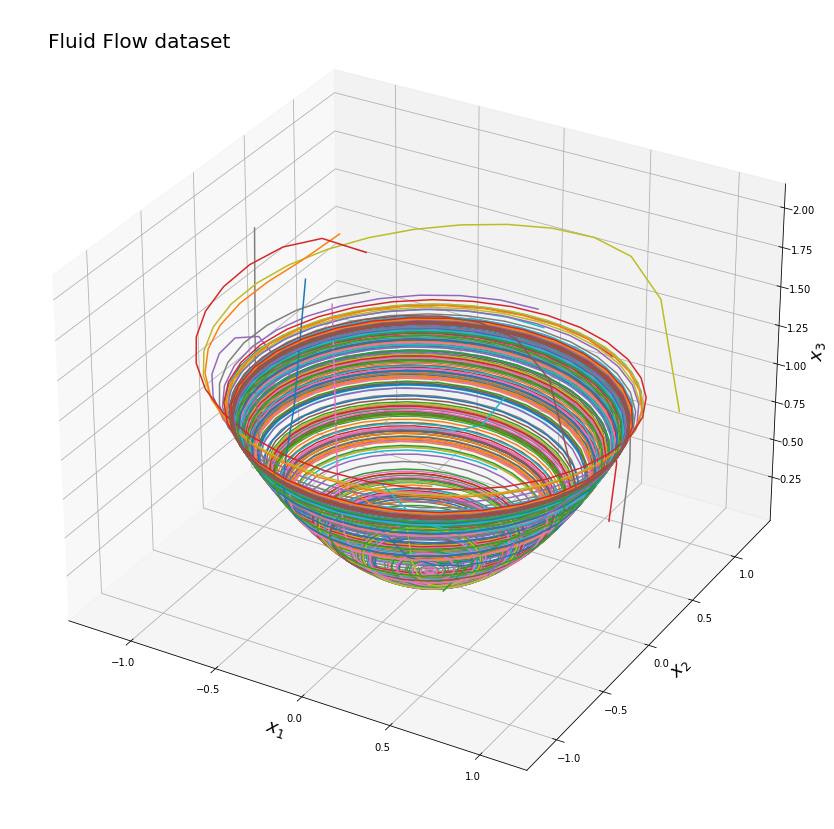

In [31]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')

for ii in np.arange(0, 1e4, 105):
    ii = int(ii)
    x1 = data[ii, 0, :]
    x2 = data[ii, 1, :]
    x3 = data[ii, 2, :]
    ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=18)
ax.set_ylabel("$x_{2}$", fontsize=18)
ax.set_zlabel("$x_{3}$", fontsize=18)
ax.text2D(0.05, 0.95, "Fluid Flow dataset", transform=ax.transAxes, fontsize=20)
plt.savefig('data/fluid_flow.png')


#ax.view_init(10, 10)
plt.show()


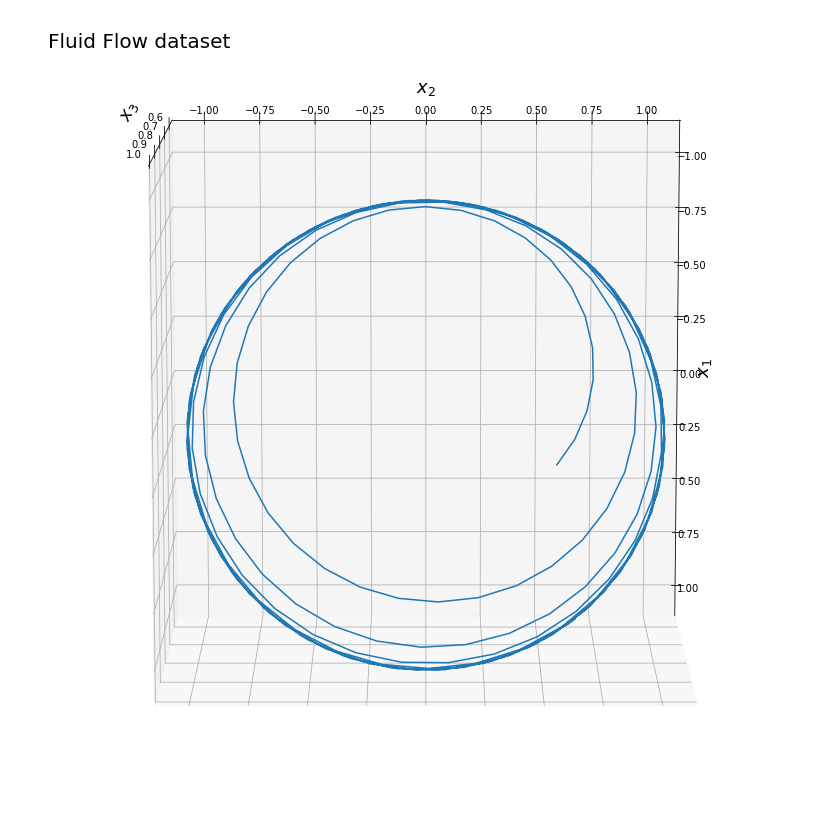

In [34]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')


ii = 0
x1 = data[ii, 0, :]
x2 = data[ii, 1, :]
x3 = data[ii, 2, :]
ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=18)
ax.set_ylabel("$x_{2}$", fontsize=18)
ax.set_zlabel("$x_{3}$", fontsize=18)
ax.text2D(0.05, 0.95, "Fluid Flow dataset", transform=ax.transAxes, fontsize=20)
plt.savefig('data/fluid_flow_overview.png')


ax.view_init(100, 0)
plt.show()


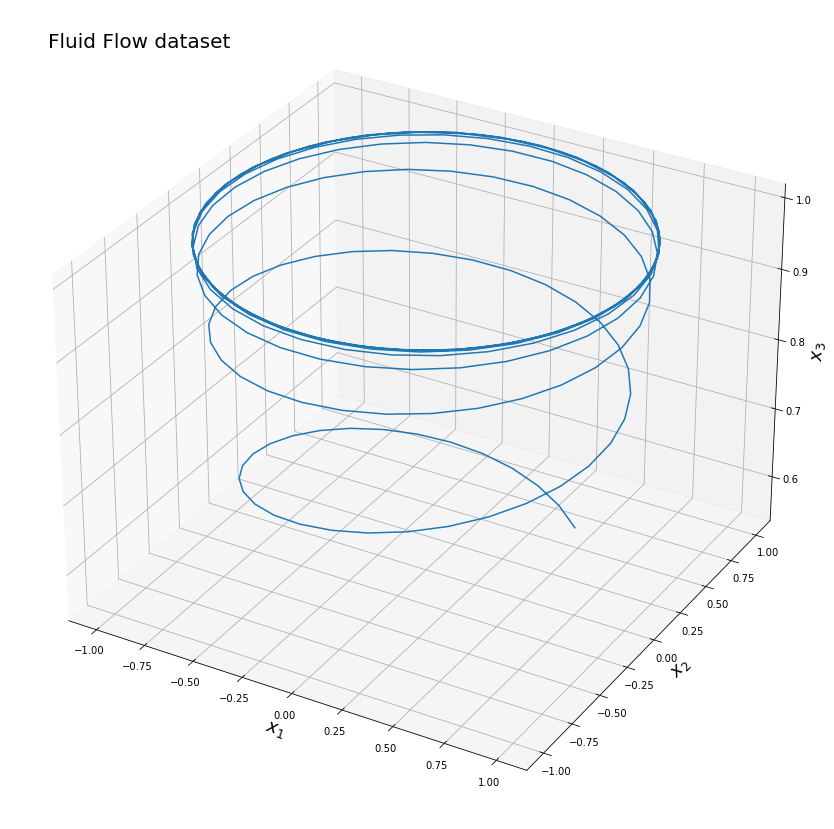

In [36]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')


ii =0 
x1 = data[ii, 0, :]
x2 = data[ii, 1, :]
x3 = data[ii, 2, :]
ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=18)
ax.set_ylabel("$x_{2}$", fontsize=18)
ax.set_zlabel("$x_{3}$", fontsize=18)
ax.text2D(0.05, 0.95, "Fluid Flow dataset", transform=ax.transAxes, fontsize=20)
plt.savefig('figures/fluid_flow_sideview.png')


plt.show()

# Evaluate DMD Loss. 


$DMD_{loss}=\arg \min _{A}\left\| {X}^{+}- A\cdot X^{-} \right\| _{F}^{2}$

$ X^{+} = A \cdot X^{-}$

By the singular value decomposition, 

$ X^{-} = U \cdot \Sigma \cdot V^{T}$

Then, 

$ A = X^{+} \cdot V \cdot \Sigma^{-1} \cdot U^{*}$,

Hence, 

$ \left\| {X}^{+}- A\cdot X^{-} \right\| _{F}^{2} = 
\left\| {X}^{+}- (X^{+} \cdot V \cdot \Sigma^{-1} \cdot U^{*})\cdot X^{-} \right\| _{F}^{2} =
\left\| {X}^{+}- (X^{+} \cdot V \cdot \Sigma^{-1} \cdot U^{*})\cdot ( U \cdot \Sigma \cdot V^{T}) \right\| _{F}^{2} = 
\left\| {X}^{+}( I - V \cdot V^{T}) \right\| _{F}^{2}$

$ Loss_{dmd} = \left\| {X}^{+}( I - V \cdot V^{T}) \right\| _{F}^{2}$

In [37]:
def dmd_loss(x_data):
    x_minus = x_data[:, :-1]
    x_plus = x_data[:, 1:]

    U, S, Vt = np.linalg.svd(x_minus, full_matrices=True)

    I = np.identity(np.shape(Vt)[0])

    VVt = np.matmul(np.transpose(Vt), Vt)

    for_norm = np.linalg.norm(np.matmul(x_plus, (I - VVt)), ord='fro')
    
    return for_norm

In [38]:
for_vec_x = np.zeros(np.shape(training_data.data_val)[0])

In [39]:
for ii in range(0, np.shape(training_data.data_val)[0]):
    loss = dmd_loss(data[ii, :, :])
    for_vec_x[ii] = loss

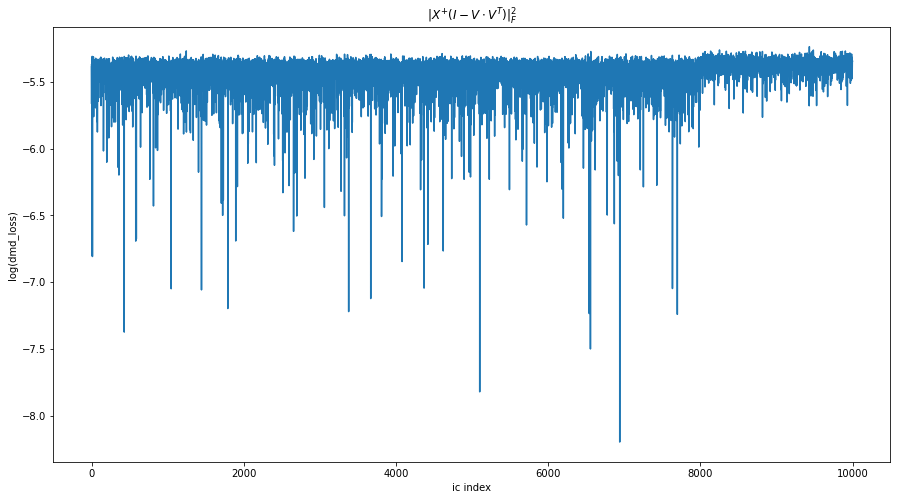

In [40]:
_ = plt.figure(figsize=(15,8))
_ = plt.plot(np.log10(for_vec_x))
_ = plt.ylabel("log(dmd_loss)")
_ = plt.xlabel("ic index")
_ = plt.title("$\| {X}^{+}( I - V \cdot V^{T})\| _{F}^{2}$")

# Apply DMD Algorithm

In [41]:
def dmd_fit(x_mat):
    # Perform DMD method
    x_minus = x_mat[:, :-1]
    x_plus = x_mat[:, 1:]

    # singular value decomposition.
    u, s, vh = np.linalg.svd(x_minus, full_matrices=False)
    u, vh = np.matrix(u), np.matrix(vh)

    # compute Atilde.
    Atilde = u.H @ x_plus @ vh.H @ np.diag(1. / s)

    # compute the eigenvalues and eigenvectors of Atilde.
    eigs, eig_vecs = np.linalg.eig(Atilde)

    # find b.
    b = np.linalg.solve(eig_vecs, x_mat[:, 0])

    # reconstruct dmd.
    dmd_rec = np.zeros((x_mat.shape[0], x_mat.shape[1]), dtype = "complex_")
    
    dmd_rec[:, 0] = x_mat[:, 0]
    
    power_lam = np.diag(np.ones(len(eigs)))
                        
    for ii in range(1, x_mat.shape[1]):
        power_lam = power_lam @ np.diag(eigs)
        dmd_rec[:, ii] = eig_vecs @ power_lam @ b
        #dmd_rec[:, ii] = (Atilde**ii) @ x_mat[:, 0]
    return [eigs, eig_vecs, b, dmd_rec]

In [46]:
random_batch = data[:10, :, :]

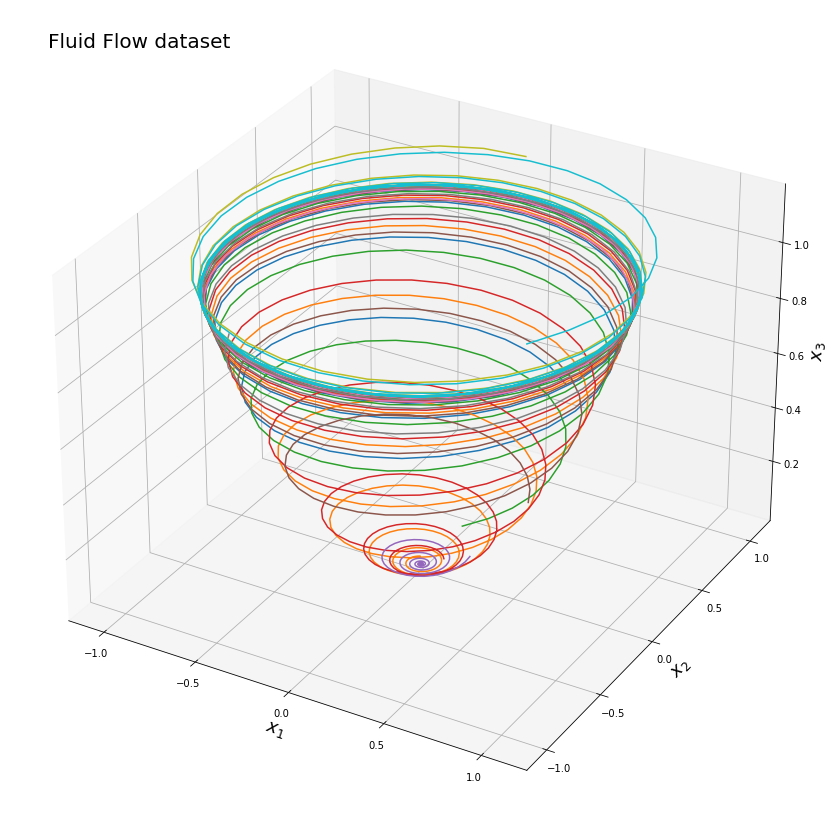

In [47]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')

for ii in np.arange(0, random_batch.shape[0]):
    x1 = random_batch[ii, 0, :]
    x2 = random_batch[ii, 1, :]
    x3 = random_batch[ii, 2, :]
    ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=18)
ax.set_ylabel("$x_{2}$", fontsize=18)
ax.set_zlabel("$x_{3}$", fontsize=18)
ax.text2D(0.05, 0.95, "Fluid Flow dataset", transform=ax.transAxes, fontsize=20)

plt.show()

In [52]:
# reshape the matrix to be 15 x timesteps 
window_size=10
reshape_mat = np.zeros((3*window_size, random_batch.shape[-1]))

for ii in range(window_size):
    reshape_mat[3* ii, :] = random_batch[ii, 0, :]
    reshape_mat[3* ii + 1, :] = random_batch[ii, 1, :]
    reshape_mat[3* ii + 2, :] = random_batch[ii, 2, :]

In [53]:
reshape_mat.shape

(30, 251)

In [59]:
# pydmd fit 
dmd = DMD(svd_rank=250)
dmd.fit(reshape_mat)
dmd_rec = dmd.reconstructed_data.real

C:\Users\Opali\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\pydmd\dmdbase.py:215: UserWarning: Input data matrix X has condition number 143912270.3992822. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  .format(cond_number))


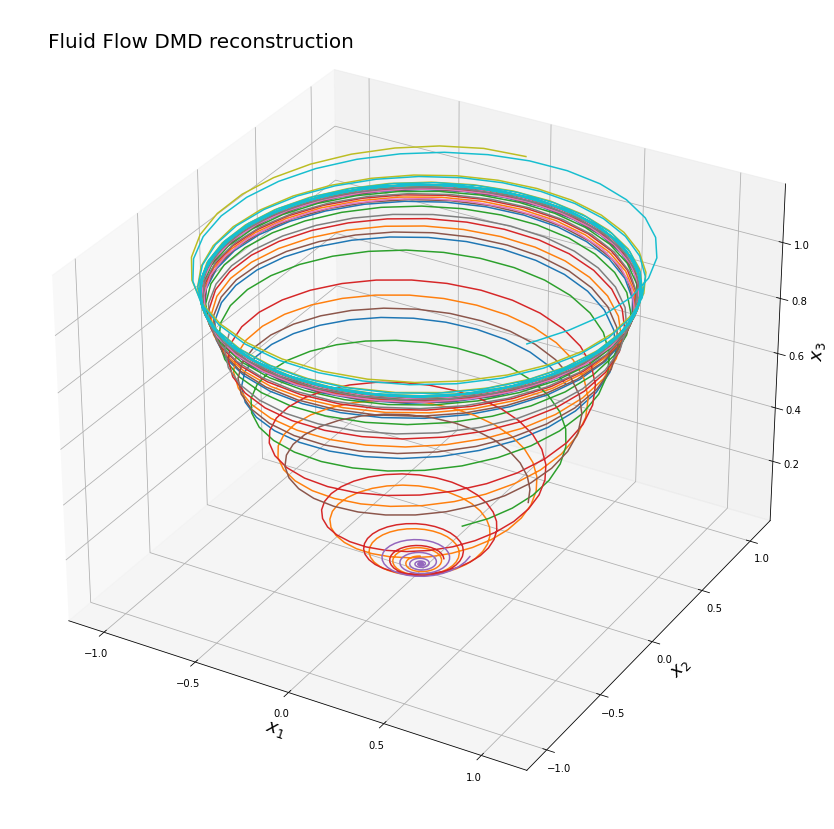

In [60]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')

for ii in np.arange(0, random_batch.shape[0]):
    x1 = dmd_rec.real[3* ii, :]
    x2 = dmd_rec.real[3* ii + 1, :]
    x3 = dmd_rec.real[3* ii + 2, :]
    ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=18)
ax.set_ylabel("$x_{2}$", fontsize=18)
ax.set_zlabel("$x_{3}$", fontsize=18)
ax.text2D(0.05, 0.95, "Fluid Flow DMD reconstruction", transform=ax.transAxes, fontsize=20)

plt.show()

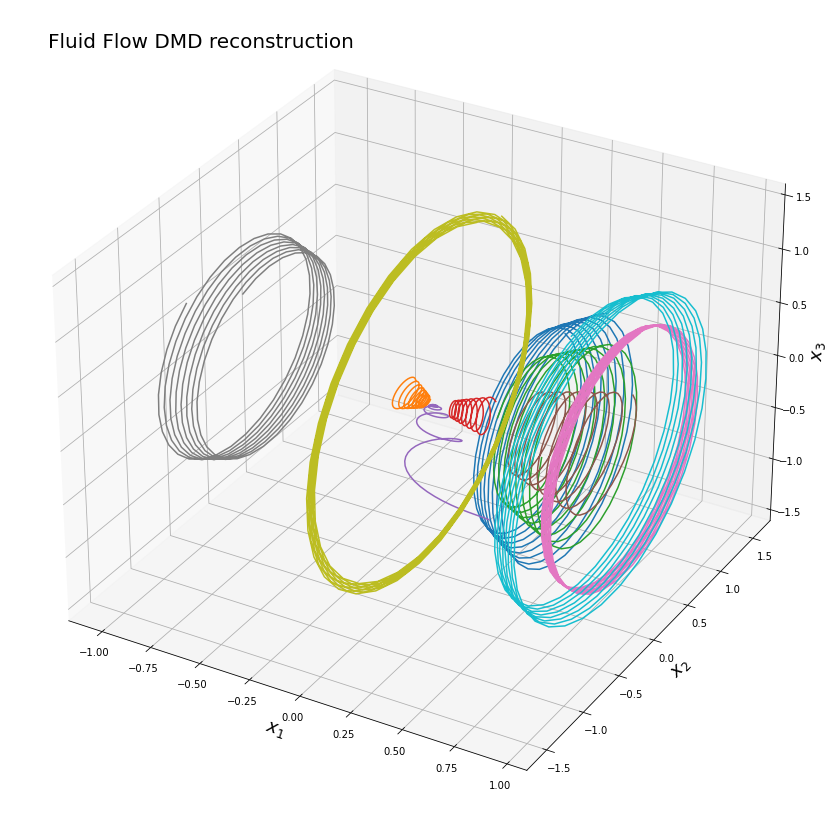

In [49]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')

dmd_rec_mat = np.zeros((random_batch.shape[0], random_batch.shape[1], random_batch.shape[2]))
for ii in np.arange(0, random_batch.shape[0]):
    eigs, eig_vecs, b, dmd_rec = dmd_fit(random_batch[ii])
    dmd_rec_mat[ii] = dmd_rec.real.astype(np.float32)
    x1 = dmd_rec_mat[ii, 0, :]
    x2 = dmd_rec_mat[ii, 1, :]
    x3 = dmd_rec_mat[ii, 2, :]
    ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=18)
ax.set_ylabel("$x_{2}$", fontsize=18)
ax.set_zlabel("$x_{3}$", fontsize=18)
ax.text2D(0.05, 0.95, "Fluid Flow DMD reconstruction", transform=ax.transAxes, fontsize=20)

plt.show()

# pyDMD reconstruction

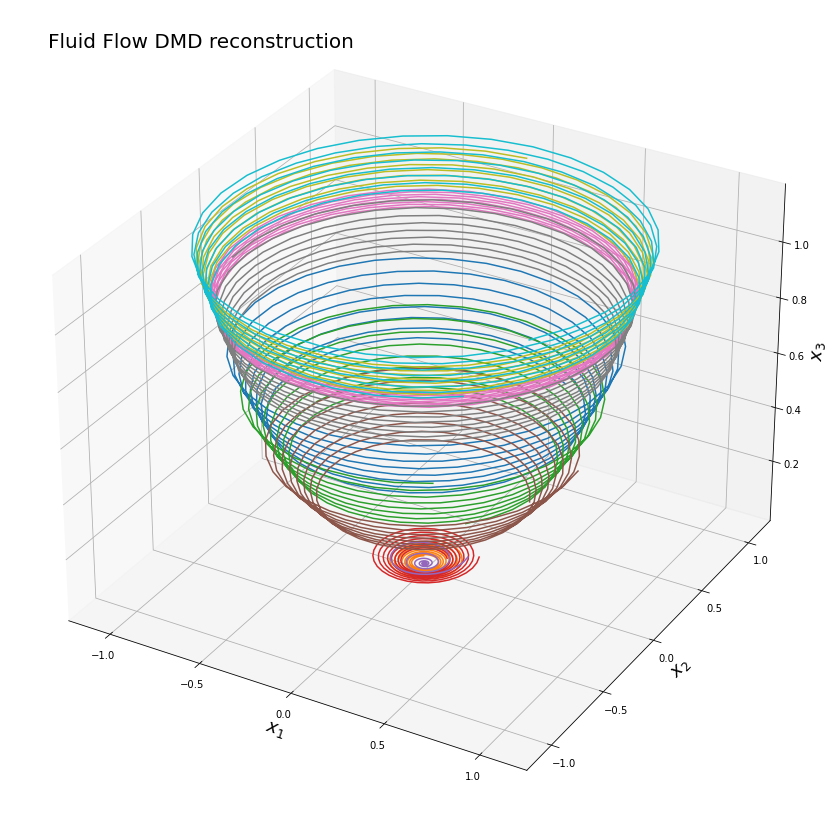

In [50]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')

dmd_rec_mat_pydmd = np.zeros((random_batch.shape[0], random_batch.shape[1], random_batch.shape[2]))
for ii in np.arange(0, random_batch.shape[0]):
    dmd = DMD(svd_rank=250)
    dmd.fit(random_batch[ii])
    dmd_rec = dmd.reconstructed_data.real
    dmd_rec_mat_pydmd[ii] = dmd_rec
    x1 = dmd_rec_mat_pydmd[ii, 0, :]
    x2 = dmd_rec_mat_pydmd[ii, 1, :]
    x3 = dmd_rec_mat_pydmd[ii, 2, :]
    ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=18)
ax.set_ylabel("$x_{2}$", fontsize=18)
ax.set_zlabel("$x_{3}$", fontsize=18)
ax.text2D(0.05, 0.95, "Fluid Flow DMD reconstruction", transform=ax.transAxes, fontsize=20)

plt.show()